In [3]:
from attention import AttentionLayer

In [4]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Add
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
ds_train = tfds.load('gigaword', split='train')
#ds_test = tfds.load('gigaword', split='test')

In [6]:
ds = ds_train.take(100000)

giga_input = []
giga_ref = []

for example in ds:
    giga_input.append(str(example['document'].numpy(), 'utf-8'))
    giga_ref.append(str(example['summary'].numpy(), 'utf-8'))

data = pd.DataFrame()

data['Text'] = giga_input
data['Summary'] = giga_ref

In [8]:
data = pd.read_csv("Giga_word_corpus.csv", nrows=1000)

In [9]:
data.head()

,Text,Summary
0,officials of the cabinet-level fair trade comm...,fair trade commission investigating consumer p...
1,"five people were killed , and a woman gravely ...",colombian nightclub shootout leaves five dead
2,preliminary dna testing on remains of ## red a...,estonia provides red army soldiers dna samples...
3,"transocean inc. , the world 's largest offshor...",transocean globalsantafe plan to combine to cr...
4,palestinian president mahmoud abbas will make ...,palestinian president to visit malaysia on may ##


In [10]:
data.to_csv("Giga_word_corpus.csv", index = False)

In [11]:
def text_cleaner(text):
    text = text.lower()
    text = text.replace(".", "")
    text = text.replace("unk", "")
    text = text.replace(" 's", "")
    tokens = text.split()
    tokens = [t for t in tokens if t.isalnum()]
    return (" ".join(tokens)).strip()

In [12]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t)) 

cleaned_text[:5]

['officials of the fair trade commission ftc said friday that they have formed an ad hoc group to investigate whether there is any manipulation of commodity prices by traders in local market',
 'five people were killed and a woman gravely wounded following a lethal shootout at a nightclub in cali colombia third largest city local authorities said monday',
 'preliminary dna testing on remains of red army soldiers uncovered at a war memorial will be conducted in russia and ukraine reports from the estonian capital of tallin said wednesday',
 'transocean inc the world largest offshore drilling contractor said monday it will combine with smaller competitor globalsantafe corp creating a company with a full range of offshore drilling services in the world key markets',
 'palestinian president mahmoud abbas will make a working visit to malaysia starting from may to malaysian foreign ministry said here on tuesday']

In [13]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t))

cleaned_summary[:5]

['fair trade commission investigating consumer price hike',
 'colombian nightclub shootout leaves five dead',
 'estonia provides red army soldiers dna samples for russia ukraine',
 'transocean globalsantafe plan to combine to create new oil drilling heavyweight',
 'palestinian president to visit malaysia on may']

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [15]:
data.head()

,Text,Summary,cleaned_text,cleaned_summary
0,officials of the cabinet-level fair trade comm...,fair trade commission investigating consumer p...,officials of the fair trade commission ftc sai...,fair trade commission investigating consumer p...
1,"five people were killed , and a woman gravely ...",colombian nightclub shootout leaves five dead,five people were killed and a woman gravely wo...,colombian nightclub shootout leaves five dead
2,preliminary dna testing on remains of ## red a...,estonia provides red army soldiers dna samples...,preliminary dna testing on remains of red army...,estonia provides red army soldiers dna samples...
3,"transocean inc. , the world 's largest offshor...",transocean globalsantafe plan to combine to cr...,transocean inc the world largest offshore dril...,transocean globalsantafe plan to combine to cr...
4,palestinian president mahmoud abbas will make ...,palestinian president to visit malaysia on may ##,palestinian president mahmoud abbas will make ...,palestinian president to visit malaysia on may


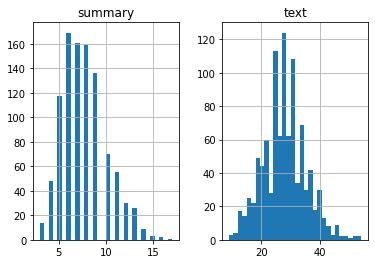

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
max_text_len = 70
max_summary_len = 15

In [18]:
df = pd.DataFrame({'text':np.array(data['cleaned_text']), 'summary':np.array(data['cleaned_summary'])})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
df.head()

,text,summary
0,officials of the fair trade commission ftc sai...,sostok fair trade commission investigating con...
1,five people were killed and a woman gravely wo...,sostok colombian nightclub shootout leaves fiv...
2,preliminary dna testing on remains of red army...,sostok estonia provides red army soldiers dna ...
3,transocean inc the world largest offshore dril...,sostok transocean globalsantafe plan to combin...
4,palestinian president mahmoud abbas will make ...,sostok palestinian president to visit malaysia...


In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [21]:
#prepare a tokenizer for reviews on training data
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(list(x_tr) + list(y_tr))

#convert text sequences into integer sequences
x_tr_seq    =   tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

y_tr_seq    =   tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
voc   =  len(tokenizer.word_index) + 1

In [22]:
voc

6436

In [23]:
x_tr.shape

(900, 70)

In [24]:
# Reference: https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras

from keras import backend as K 
K.clear_session() 
latent_dim = x_tr.shape[0]

# Encoder 
encoder_inputs = Input(shape=(max_text_len,)) 
enc_emb = Embedding(voc, latent_dim,trainable=True)(encoder_inputs) 

forward_layer = LSTM(latent_dim, return_sequences=True, return_state=True)
backward_layer = LSTM(latent_dim, return_sequences=True, return_state=True, go_backwards=True)

bidirectional_lstm = Bidirectional(forward_layer, backward_layer=backward_layer)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = bidirectional_lstm(enc_emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(voc, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state1 = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 900)      5792400     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 70, 1800), ( 12967200    embedding[0][0]                  
______________________________________________________________________________________________

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [26]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30, validation_split=0.2)

Epoch 1/30
23/23 [==============================] - 20s 856ms/step - loss: 5.4016 - val_loss: 4.5559
Epoch 2/30
23/23 [==============================] - 18s 793ms/step - loss: 4.2019 - val_loss: 4.6280
Epoch 3/30
23/23 [==============================] - 18s 798ms/step - loss: 3.9888 - val_loss: 4.6542
Epoch 4/30
23/23 [==============================] - 18s 790ms/step - loss: 3.8372 - val_loss: 4.7636
Epoch 5/30
23/23 [==============================] - 18s 784ms/step - loss: 3.6600 - val_loss: 4.8111
Epoch 6/30
23/23 [==============================] - 18s 791ms/step - loss: 3.4265 - val_loss: 4.9461
Epoch 7/30
23/23 [==============================] - 18s 788ms/step - loss: 3.1680 - val_loss: 5.0609
Epoch 8/30
23/23 [==============================] - 18s 794ms/step - loss: 2.8327 - val_loss: 5.2758
Epoch 9/30
23/23 [==============================] - 18s 788ms/step - loss: 2.4554 - val_loss: 5.4826
Epoch 10/30
23/23 [==============================] - 18s 801ms/step - loss: 2.0304 - val_lo

In [27]:
model.save("Giga_model_1.h5", save_format="h5")

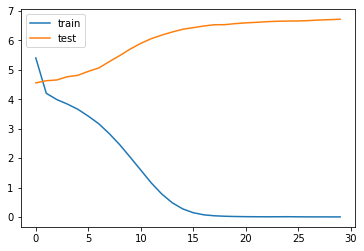

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
reverse_word_index=tokenizer.index_word
word_index=tokenizer.word_index

In [30]:
# Reference: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        try:
            sampled_token = reverse_word_index[sampled_token_index]
        except KeyError as e:
            sampled_token = 'unk'
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=word_index['sostok']) and i!=word_index['eostok']):
            try:
                newString=newString+reverse_word_index[i]+' '
            except KeyError:
                newString=newString+'unk '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            try:
                newString=newString+reverse_word_index[i]+' '
            except KeyError:
                newString=newString+'unk '
    return newString

In [33]:
original = []
created = []

for i in range(0,x_val.shape[0]):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    original.append(str(seq2summary(y_val[i])))

    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    created.append(str(decode_sequence(x_val[i].reshape(1,max_text_len))))

    print("\n")

Review: us defense secretary robert gates has asked nato allies and colleagues for more effort in afghanistan but it is too early to tell whether his will pay off 
Original summary: whether gates drive for more help in afghanistan will 
Predicted summary:  british pm vows to hold second referendum on eu treaty


Review: a court ruled friday that a strike by greek over tax breaks was illegal and an abuse of their position as the agreed to step up their action 
Original summary: court declares greek strike illegal 
Predicted summary:  eu president to mediate crisis between venezuela colombia


Review: the owner of boston center is expected to lose more than half of the of prime property it has slated for after the hall goes on the auction block thursday 
Original summary: auction threatens development 
Predicted summary:  composition of seats in new spanish parliament


Review: a former communications international inc chief financial officer pleaded guilty thursday to a single count of 